# Section 0 : Initialize and define preprocessing class 

The PCA_scaler class takes as input a list of data ("bkgdata") and an integer ("bins"). 

The list of data should be in the form:
"mass, pT, tau_(1)^(1/2),tau_(1)^(1),tau_(1)^(2),tau_(2)^(1/2),tau_(2)^(1),tau_(2)^(2),tau_(3)^(1/2),tau_(3)^(1),tau_(3)^(2),tau_(4)^(1),tau_(4)^(2)" and it is used to define the rotation matrices of the PCA_Scaler. 

The integer "bins" specifies the number of bins in which I want to devide my datasample. Right now this number is choosen to be close to the one used in 1709.01087, in the future we could try to change the number of bins to see if the performances improve.
The size of each bin is auomatically chosen in such a way that the number of bkg events in each bin is the same bin. 

Associated to the PCA_scaler class there is the "transform" function. This function take a list of data (with the same structure of the one used to initialize the PCA_scaler) and applies to it the rotation matrices of the scaler.

In [1]:
import os
import numpy as np
import numpy.random as rand
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.decomposition import PCA
from collections import OrderedDict

class PCA_scaler:
    
    def __init__(self,bkgdata,bins):
        eventxbin = len(bkgdata) / bins
        bkgdata = bkgdata[bkgdata[:,0].argsort()]
        bkgdatabinned = []
        self.binboundaries = []
        for i in range(0,bins):
            bkgdatabinned.append(bkgdata[i*eventxbin: (i+1)*eventxbin,2:])
            self.binboundaries.append(bkgdata[i*eventxbin,0])
        
        self.scale1 = [preprocessing.StandardScaler().fit(databin) for databin in bkgdatabinned]
        tempdata = [self.scale1[i].transform(databin) for i, databin in enumerate(bkgdatabinned)]
        self.mypca = [PCA().fit(tempdatarow) for tempdatarow in tempdata]
        newtempdata = [self.mypca[i].transform(tempdatarow) for i, tempdatarow in enumerate(tempdata)]
        self.scale2 = [preprocessing.StandardScaler().fit(tempdatarow) for tempdatarow in newtempdata]
        
    def transform(self,inputdata):
        inputdatabinned = []
        inputmassbinned = []
        for i in range(0,len(self.binboundaries)-1):
            inputdatabinned.append(
                np.array([myrow[2:] for myrow in inputdata
                         if (myrow[0] < self.binboundaries[i+1] and myrow[0] >= self.binboundaries[i])])
            )
            inputmassbinned.append(
                np.array([myrow[0:1] for myrow in inputdata
                         if (myrow[0] < self.binboundaries[i+1] and myrow[0] >= self.binboundaries[i])])
            )
        scaleddatabinned = [np.insert(np.dot(self.scale2[i].transform(self.mypca[i].transform(self.scale1[i].transform(inputdatarow))),
                                    self.mypca[i].components_),[0],inputmassbinned[i],axis = 1)
                            if len(inputdatarow) > 0 else []
                            for i, inputdatarow in enumerate(inputdatabinned)]
        return scaleddatabinned
        
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def WritePickle(x_data, y_data, filename):
    data = {'x_data': x_data, 'y_data':y_data}
    pickle.dump(data, open (filename , "wb"))

# Section 1: Load and preprocess bkg and signal data

Load and shuffle signal and background datasamples

In [2]:
data_folder = "/Users/Andrea/Dropbox/Ongoing Works/ExploringDecorrelationMethods/Data/BSM_2P_3P_4P_BigDataSet/"
bkgdata = np.loadtxt(data_folder + "data_bkg.txt", delimiter = ",")
rand.shuffle(bkgdata)
sigdata = np.loadtxt(data_folder + "data_sig_4p.txt", delimiter = ",")
rand.shuffle(sigdata)

### Initialize the PCA preprocessor

The preprocessor is initialized on the whole bkg sample

In [3]:
bins = 50
preprocessor = PCA_scaler(bkgdata,bins)
bkgdatabinned = preprocessor.transform(bkgdata)

Here we get the bin boundaries and the bin content.

In [4]:
binboundaries = preprocessor.binboundaries
bincenters = [0.5*(binboundaries[i+1] + binboundaries[i]) for i in range(0,len(binboundaries)-1)]
binwidths = [binboundaries[i+1] - binboundaries[i] for i in range(0,len(binboundaries)-1)]
bincontents = [len(myrow) for myrow in bkgdatabinned]
bindensities = [bincontents[i] / binwidths[i] for i in range(0,len(binwidths))]
#print(list(enumerate(binboundaries)))
#print(list(enumerate(bincenters)))
#print(list(enumerate(bincontents)))

### Plot of the background before any tagging has happened

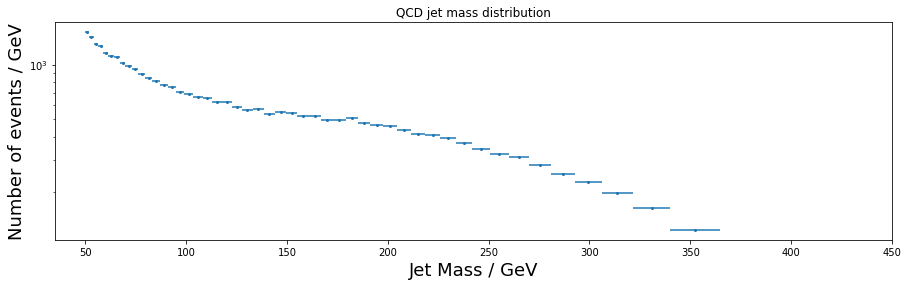

In [5]:
axislabelsize = 18

yerr = np.divide(1,np.sqrt(np.array(bincontents)))
xerr = np.multiply(0.5,np.array(binwidths))
plt.figure(figsize=(15,4))
plt.semilogy()
plt.xlim(35,450)
plt.errorbar(bincenters, bindensities, xerr=xerr, yerr=yerr,fmt='o',markersize=2)
plt.xlabel('Jet Mass / GeV', size=axislabelsize)
plt.ylabel('Number of events / GeV', size=axislabelsize)
plt.title('QCD jet mass distribution')
plt.show()

# Part 2: Define and train the NN

## Definition of the training and testing samples

Split the data in training and testing samples

In [6]:
bkgdatabinned_train_and_val = preprocessor.transform(bkgdata[:int(len(bkgdata)*0.2)])
bkgdatabinned_test = preprocessor.transform(bkgdata[int(len(bkgdata)*0.2):])

sigdatabinned_train_and_val = preprocessor.transform(sigdata[:int(len(sigdata)*0.2)])
sigdatabinned_test = preprocessor.transform(sigdata[int(len(sigdata)*0.2):])

sig_test = np.array(sigdatabinned_test[0])
bkg_test = np.array(bkgdatabinned_test[0])
for i in range(1,bins - 1):
    sig_test = np.append(sig_test,sigdatabinned_test[i],axis=0)
    bkg_test = np.append(bkg_test,bkgdatabinned_test[i],axis=0)
data_test = np.append(bkg_test,sig_test,axis=0)
labels_test = np.append(np.zeros(len(bkg_test)),np.ones(len(sig_test)))

Select a mass window for training and take the background events in that mass window  

In [7]:
# Define the mass window and find the corrisponding bin window
masswindow = [100,150]
leftbin = np.where(binboundaries==find_nearest(binboundaries,masswindow[0]))[0][0]
rightbin = np.where(binboundaries==find_nearest(binboundaries,masswindow[1]))[0][0]

# Take the background and signal events in the masswindow from the training sample 
bkgmasswindow = np.array(bkgdatabinned_train_and_val[leftbin])
sigmasswindow = np.array(sigdatabinned_train_and_val[leftbin])
for i in range(leftbin+1, rightbin+1):
    bkgmasswindow = np.append(bkgmasswindow,bkgdatabinned_train_and_val[i],axis=0)
    sigmasswindow = np.append(sigmasswindow,sigdatabinned_train_and_val[i],axis=0)
rand.shuffle(bkgmasswindow)
rand.shuffle(sigmasswindow)
print len(bkgmasswindow), len(sigmasswindow)

6669 6638


Split the training_and_validation sample into training and validation samples

In [8]:
valfrac = 0.2

bkg_train = bkgmasswindow[int(valfrac*len(bkgmasswindow)):]
bkg_val = bkgmasswindow[:int(valfrac*len(bkgmasswindow))]

sig_train = sigmasswindow[int(valfrac*len(sigmasswindow)):]
sig_val = sigmasswindow[:int(valfrac*len(sigmasswindow))]

data_train = np.append(bkg_train,sig_train,axis=0)
labels_train = np.append(np.zeros(len(bkg_train)),np.ones(len(sig_train)))

data_val = np.append(bkg_val,sig_val,axis=0)
labels_val = np.append(np.zeros(len(bkg_val)),np.ones(len(sig_val)))

perms_train = rand.permutation(len(data_train))
data_train = data_train[perms_train]
labels_train = labels_train[perms_train]

perms_val = rand.permutation(len(data_val))
data_val = data_val[perms_val]
labels_val = labels_val[perms_val]

# Definition of the NN

Right now the NN is defined as in 1709.01087 (i.e (512,36,1)) . I am noticing just now that in the draft the refrence NN is defined to be (50,50,50,1), I can change it to match the draft convention. 

In [9]:
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pickle as pickle
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss', patience=5,verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', patience=3,verbose=1)

mycallbacks=[early_stopping, reduce_LR]
batch_size=500

models = {}
models_hist = {}

ntries = 5

sig_predict={}
bg_predict={}

Using TensorFlow backend.


Train the model fot 'ntries' times and take the best (the one with the best ROC curve)

Train on 10647 samples, validate on 2660 samples
Epoch 1/100
10647/10647 [==============================] - 0s 27us/step - loss: 0.4271 - acc: 0.8564 - val_loss: 0.2902 - val_acc: 0.9180
Epoch 2/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.2421 - acc: 0.9251 - val_loss: 0.2162 - val_acc: 0.9229
Epoch 3/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1970 - acc: 0.9300 - val_loss: 0.1929 - val_acc: 0.9263
Epoch 4/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1818 - acc: 0.9323 - val_loss: 0.1831 - val_acc: 0.9301
Epoch 5/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1738 - acc: 0.9343 - val_loss: 0.1793 - val_acc: 0.9346
Epoch 6/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1694 - acc: 0.9376 - val_loss: 0.1715 - val_acc: 0.9293
Epoch 7/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1652 - acc: 0.9385 - val_loss: 0.1698 - val_acc

Epoch 11/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1544 - acc: 0.9401 - val_loss: 0.1657 - val_acc: 0.9305
Epoch 12/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1529 - acc: 0.9413 - val_loss: 0.1637 - val_acc: 0.9312
Epoch 13/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1509 - acc: 0.9413 - val_loss: 0.1613 - val_acc: 0.9331
Epoch 14/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1501 - acc: 0.9421 - val_loss: 0.1674 - val_acc: 0.9312
Epoch 15/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1483 - acc: 0.9429 - val_loss: 0.1625 - val_acc: 0.9320
Epoch 16/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1465 - acc: 0.9441 - val_loss: 0.1687 - val_acc: 0.9316

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
Epoch 17/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1464 - acc: 0.

Epoch 22/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1447 - acc: 0.9453 - val_loss: 0.1582 - val_acc: 0.9372
Epoch 23/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1445 - acc: 0.9445 - val_loss: 0.1582 - val_acc: 0.9383

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 24/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1440 - acc: 0.9454 - val_loss: 0.1582 - val_acc: 0.9380
Epoch 25/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1440 - acc: 0.9451 - val_loss: 0.1582 - val_acc: 0.9383
Epoch 26/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1440 - acc: 0.9451 - val_loss: 0.1582 - val_acc: 0.9383

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.00000006569e-06.
Epoch 27/100
10647/10647 [==============================] - 0s 5us/step - loss: 0.1440 - acc: 0.9451 - val_loss: 0.1582 - val_acc: 0.9383
Epoch 28/100
10647/

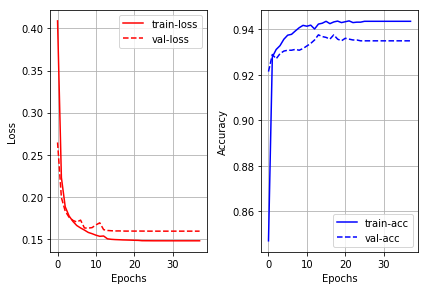

In [10]:
#Train baby, train!
#This will train five times and pick the very best.

model_name = 'PCA_alltaus'

numvars= 11
aucs = list()
aucmax=0
for i in range(ntries):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=numvars))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model_hist = model.fit(data_train[:,1:1+numvars], labels_train, epochs=100, batch_size=batch_size,
                        validation_data=(data_val[:,1:1+numvars],labels_val),callbacks=mycallbacks,verbose=1)

    newauc = roc_auc_score(labels_val,model.predict(data_val[:,1:1+numvars]))
    aucs.append(newauc)
    print(newauc)
    if newauc > aucmax:
        aucmax = newauc
        
        models[model_name] = model
        models_hist[model_name] = model_hist
        
print(aucs)


np.seterr(divide = 'ignore') 

plt.subplot(1,2,1)
plt.plot(model_hist.history['loss'],'r',label = "train-loss")
plt.plot(model_hist.history['val_loss'],'r--',label = "val-loss")
leg = plt.legend() 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(model_hist.history['acc'],'b',label = "train-acc")
plt.plot(model_hist.history['val_acc'],'b--',label = "val-acc")
leg = plt.legend() 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()
#plt.savefig("/Users/Andrea/Desktop/prova.pdf")
plt.close()


#Save the model
#models[model_name].save(model_name+'.h5')
#with open(model_name, 'wb') as file_pi:
#    pickle.dump(models_hist[model_name].history, file_pi)
#    
#with open(model_name+'.h5', 'wb') as file_pi:
#    pickle.dump(models_hist[model_name].history, file_pi)

Checks that the signal efficiency (for different thresholds) remain constant varying the Jet mass

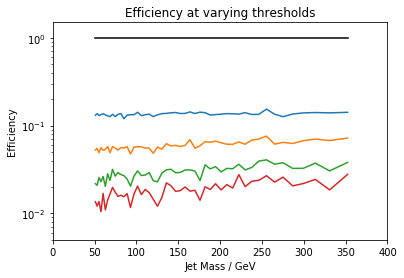

In [11]:
mymodel=models['PCA_alltaus']
bkgpredicttable = [mymodel.predict(data[:,1:1+numvars]) for data in bkgdatabinned_test]

thresholds = [0,0.2,0.55,0.8,0.89]
binefficiencies = [
    [float(np.count_nonzero(predictions > threshold))/len(predictions) for predictions in bkgpredicttable]
    for threshold in thresholds
]
bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in bkgpredicttable]
    for threshold in thresholds
]

plt.close('all')
colours=('k','C0','C1','C2','C3')
for i in range(0,len(thresholds)):
    plt.plot(bincenters,binefficiencies[i],color=colours[i])
plt.semilogy()
plt.xlim([0,400])
plt.ylim([0.005,1.5])
plt.xlabel('Jet Mass / GeV')
plt.ylabel('Efficiency')
plt.title('Efficiency at varying thresholds')
plt.show()

Plot the bkg events that pass the cut for different values of the thresold

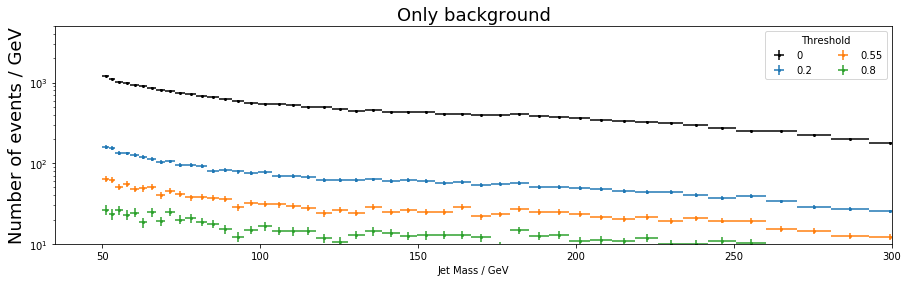

In [13]:
labels_prediction = mymodel.predict(data_test[:,1:1+numvars])
threshold_choices=[0,1,2,3]

axislabelsize = 18

plt.close('all')
plt.figure(figsize=(15,4))

colours=('k','C0','C1','C2','C3')

yerr0 = np.multiply(np.divide(np.sqrt(np.add(np.array(bincontents),1)),binwidths),0.89)
yerrs = np.divide(np.sqrt(np.add(np.array(bincutcounts),1)),binwidths)
xerr = np.multiply(0.5,np.array(binwidths))

plt.semilogy()
plt.ylim(10,5e3)
plt.xlim(35,300)
plt.xlabel('Jet Mass / GeV')
plt.ylabel('Number of events / GeV', size=axislabelsize)
plt.title(r'Only background', size=axislabelsize)
for i in range(0,len(threshold_choices)):
    #yerr = np.sqrt(np.add(np.array(bincutcounts[i]),1))
    plt.errorbar(bincenters,np.divide(bincutcounts[threshold_choices[i]],binwidths),
                 xerr=xerr, yerr=yerrs[threshold_choices[i]],fmt='o',markersize=2,
                 color=colours[i],label=thresholds[i])
plt.legend(title='Threshold',ncol=2)
plt.show()

In [14]:
sigpredicttable = [mymodel.predict(data[:,1:1+numvars]) if len(data) > 0 else np.array([0.])
                      for data in sigdatabinned_test]
sigbincontents = [len(row) for row in sigdatabinned_test]

sigbinefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in sigpredicttable]
    for threshold in thresholds
]
sigbincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in sigpredicttable]
    for threshold in thresholds
]
sigbincutdensities = np.divide(sigbincutcounts,binwidths)

sigplusbgcut = [np.add(np.array(bincutcounts[i]),sigbincutcounts[i])
                for i in range(0,len(bincutcounts))]

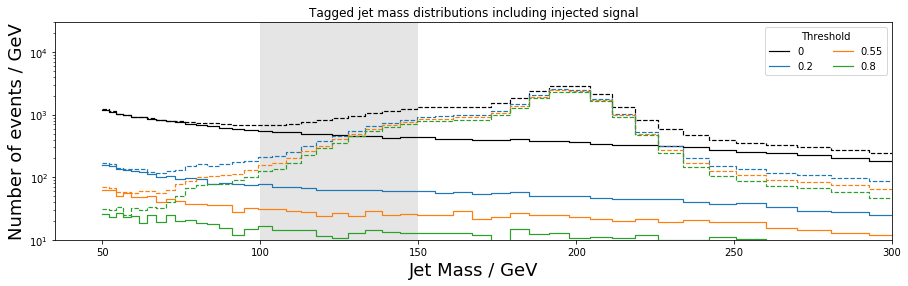

In [15]:
#Now lets plot that bitch!

axislabelsize = 18

plt.close('all')

threshold_choices=[0,1,2,3]
colours=['k','C0','C1','C2','C3']

plt.figure(figsize=(15,4))


yerr0 = np.multiply(np.divide(np.sqrt(np.add(np.array(bincontents),1)),binwidths),0.89)
yerrs = np.divide(np.sqrt(np.add(np.array(bincutcounts),1)),binwidths)
xerr = np.multiply(0.5,np.array(binwidths))

'''
axes2d[0].semilogy()
axes2d[0].axvspan(65, 105, alpha=0.2, facecolor='gray')
axes2d[0].set_ylim(10,3e4)
axes2d[0].set_xlim(35,300)
#plt.xlabel('Jet Mass / GeV')
axes2d[0].set_ylabel('Number of events / GeV', size=axislabelsize)
axes2d[0].set_title(r'$p_T > 1000$ GeV', size=axislabelsize)
axes2d[0].errorbar(bincenters, np.multiply(bindensities,0.8), xerr=xerr, yerr=yerr0,fmt='o',markersize=2,color='k')

for i in range(0,len(threshold_choices)):
    #yerr = np.sqrt(np.add(np.array(bincutcounts[i]),1))
    axes2d[0].errorbar(bincenters,np.divide(bincutcounts[threshold_choices[i]],binwidths),
                 xerr=xerr, yerr=yerrs[threshold_choices[i]],fmt='o',markersize=2,color=colors[i])
'''

linewidth=1.2
plt.semilogy()
plt.ylim(10,3e4)
plt.xlim(35,300)
plt.axvspan(masswindow[0], masswindow[1], alpha=0.2, facecolor='gray')
plt.xlabel('Jet Mass / GeV', size=axislabelsize)
plt.ylabel('Number of events / GeV', size=axislabelsize)
#plt.title(r'$p_T > 500$ GeV')
for i in range(0,len(threshold_choices)):
    plt.step(binboundaries[:len(binboundaries)-1],
            np.divide(bincutcounts[threshold_choices[i]],binwidths),
            where='post',color=colours[i],linewidth=linewidth,label=thresholds[i])
    
for i in range(0,len(threshold_choices)):
    plt.step(binboundaries[:len(binboundaries)-1],
             np.divide(sigplusbgcut[threshold_choices[i]],binwidths),
             where='post',color=colours[i],linestyle='--',linewidth=linewidth)
plt.legend(title='Threshold',ncol=2)
plt.title('Tagged jet mass distributions including injected signal')
plt.show()

Export the p files for the ROC curve and the hostrograms 

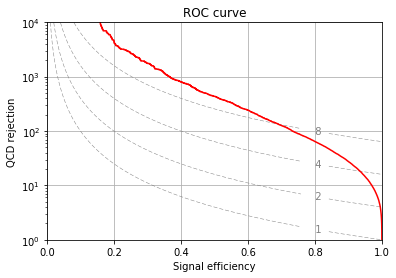

0.05
0.060000000000000005
0.07
0.08
0.09
0.1
0.11
0.12000000000000001
0.13
0.14
0.15000000000000002
0.16
0.16999999999999998
0.18
0.19
0.2
0.21000000000000002
0.22000000000000003
0.22999999999999998
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.33999999999999997
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.5900000000000001
0.6000000000000001
0.6100000000000001
0.6200000000000001
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.7200000000000001
0.7300000000000001
0.7400000000000001
0.7500000000000001
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.8500000000000001
0.8600000000000001
0.8700000000000001
0.8800000000000001
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.9700000000000001
0.9800000000000001
0.9900000000000001
1.0


In [16]:
folder = "/Users/Andrea/Desktop/pfiles/"

############################################### ROC CURVE ####################################################

metric = metrics.roc_curve(labels_test.flatten(),labels_prediction.flatten())
roc_AreaUnderCurve  = metrics.roc_auc_score(labels_test.flatten(), labels_prediction.flatten())

WritePickle(metric[1],np.divide(1,metric[0]), folder + "PCA_ROC_4p.p")
plt.plot(metric[1], np.divide(1, metric[0]), 'r', linewidth = 1.5)
gridwidth = 0.5
dashes = [8,4]
dotdashes = [8,4,1,4]
delta = 0.025
x = np.arange(0, 1.0 + delta, delta)
logy = np.arange(0,math.log(1e4), delta)
y = np.exp(logy)
X, Y = np.meshgrid(x, y)
Z = np.multiply(X,np.power(Y,0.5))
manual_locations = [(0.8,1/(0.8*0.8)),(0.8,4/(0.8*0.8)), (0.8,16/(0.8*0.8)), (0.8,64/(0.8*0.8))]
CS = plt.contour(X, Y, Z,[1,2,4,8], colors = 'gray',linestyles = 'dashed',linewidths = gridwidth)
for c in CS.collections:
    c.set_dashes([(0,(8,4))])
plt.clabel(CS, inline = 1, fontsize = 10,fmt = '%3.0f',manual = manual_locations)
plt.axis([0, 1, 1, 10000])
plt.xlabel('Signal efficiency')
plt.ylabel('QCD rejection')
plt.yscale('log')
plt.title('ROC curve')
plt.grid(True)
plt.show()
#plt.savefig(folder + "PCA_ROC_3p.pdf")
plt.close()

############################################# DISTANCE PLOT #################################################
big_dict = OrderedDict()

y_prediction        = mymodel.predict(data_test[:,1:])
metric = metrics.roc_curve(labels_test.flatten(), y_prediction.flatten())

data1 = sig_test
data2 = bkg_test
signal_efficiency_tab = np.linspace(0.05,1,96)

eff_dict = OrderedDict()

for eff in signal_efficiency_tab:
    threshold = metric[2][np.where(metric[1] == (find_nearest(metric[1],eff)))][0]

    data1_post = []
    data2_post = []

    data1_predict = model.predict(data1[:,1:1+numvars])
    data2_predict = model.predict(data2[:,1:1+numvars])

    count = 0
    for iter in data1_predict:
        if iter > threshold:
            data1_post.append(data1[count])
        count += 1

    count = 0
    for iter in data2_predict:
        if iter > threshold: 
            data2_post.append(data2[count])
        count += 1

    data1_post = np.array(data1_post)
    data2_post = np.array(data2_post)


    eff_dict[eff] = (data1_post[:,0],data2_post[:,0])

#    bins=50
    
#    if 0.69<eff< 0.71 or 0.89<eff<0.91:
#        plt.figure()
#        plt.hist(data1_post[:,0],density = True,bins = bins, alpha = 0.5,label = "signal", histtype = 'step',color ='r' )
#        plt.hist(data2_post[:,0],density = True,bins = bins, alpha = 0.5,label = "bkg", histtype = 'step',color ='b')
#        plt.hist(data1[:,0],density = True,bins = bins, alpha = 0.5,label = "sig_noCut", histtype = 'step',color = 'r', linestyle = '--')  
#        plt.hist(data2[:,0],density = True,bins = bins, alpha = 0.5,label = "bkg_noCut", histtype = 'step',color ='b', linestyle = '--')

#        plt.savefig(os.path.dirname(os.path.abspath("PCA.ipynb"))+'/PCA/PCA_mass' + str(eff) + '.pdf')
#        plt.close()
    
    
    print(eff)

big_dict["PCA"] = eff_dict
pickle.dump(big_dict, open (folder + 'PCA_hist_4p.p', "wb"))
